# **Regresión Logistica: Estadísticas de Divorcio (INEGI, 2023)**

Carlos Hernández Márquez

"Doy mi palabra que he realizado esta actividad con integridad académica"

# **Importación de datos y definición de la variable de salida**

Se cargó la base **`Estadísticas_divorcios_Mexico_2023_P1.csv`** en un DataFrame de pandas.  
La base contiene **155 columnas** y múltiples registros relacionados con las estadísticas de divorcio en México.  
La dimensión de la base (`df.shape`), confirmando la estructura completa de filas y columnas disponibles.

In [46]:
import pandas as pd

df = pd.read_csv("Estadisticas_divorcios_Mexico_2023_P1.csv")

display(df.head())
display(df.shape)

,hijos,cus_hij,edad_div1,edad_div2,dura_leg,misma_entidad,mismo_municipio,mismo_sexo,misma_nacionalidad,misma_tloc,...,anio_reg_2014.0,anio_reg_2015.0,anio_reg_2016.0,anio_reg_2017.0,anio_reg_2018.0,anio_reg_2019.0,anio_reg_2020.0,anio_reg_2021.0,anio_reg_2022.0,anio_reg_2023.0
0,4,2,41.0,42.0,18.0,True,True,False,True,True,...,False,False,False,False,False,False,False,False,True,False
1,2,2,30.0,29.0,18.0,True,True,False,True,True,...,False,False,False,False,False,False,False,False,False,True
2,0,0,68.0,42.0,56.0,True,True,False,True,True,...,False,False,False,False,False,False,False,False,True,False
3,5,0,70.0,73.0,54.0,True,True,False,True,True,...,False,False,False,False,False,False,False,False,True,False
4,4,0,75.0,72.0,54.0,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,True


(156669, 155)

El dataset fue cargado exitosamente, con un número amplio de variables (155), lo que permitirá realizar procesos de selección de características más adelante. La variable de interés `dura_leg` (duración legal del matrimonio) está presente y será la base para la creación de la variable binaria de salida en el siguiente paso.

La binarizamos con el criterio:
- `dura_leg_bin = 1` si `dura_leg` > promedio de `dura_leg` (en el conjunto disponible).
- `dura_leg_bin = 0` en otro caso.

También limpiamos `dura_leg` a numérico, removemos nulos en esa columna, y reportamos el promedio y el balance de clases.


In [47]:
import numpy as np

n_nulos = df['dura_leg'].isna().sum()
print(f"Nulos en 'dura_leg' antes de limpiar: {n_nulos}")
df = df.dropna(subset=['dura_leg']).copy()

mean_dura_leg = df['dura_leg'].mean()
print(f"Promedio de 'dura_leg': {mean_dura_leg:.4f}")

df['dura_leg_bin'] = (df['dura_leg'] > mean_dura_leg).astype(int)

display(df[['dura_leg', 'dura_leg_bin']].head())

counts = df['dura_leg_bin'].value_counts().sort_index()
props = df['dura_leg_bin'].value_counts(normalize=True).sort_index()

print("\nConteo por clase en 'dura_leg_bin':")
for cls in [0, 1]:
    c = int(counts.get(cls, 0))
    p = props.get(cls, 0.0)
    print(f"Clase {cls}: {c} observaciones ({p:.2%})")

y_col = 'dura_leg_bin'
print(f"\nVariable de salida definida: {y_col}")


Nulos en 'dura_leg' antes de limpiar: 0
Promedio de 'dura_leg': 16.6909


,dura_leg,dura_leg_bin
0,18.0,1
1,18.0,1
2,56.0,1
3,54.0,1
4,54.0,1



Conteo por clase en 'dura_leg_bin':
Clase 0: 86450 observaciones (55.18%)
Clase 1: 70219 observaciones (44.82%)

Variable de salida definida: dura_leg_bin


La variable binaria de salida quedó bien definida y mantiene un **balance relativamente adecuado** (55% vs 45%). Esto es importante porque evita un sesgo fuerte hacia una de las clases en la fase de modelado. La variable `dura_leg_bin` será la salida a predecir en los siguientes pasos.


## **División del conjunto de datos en entrenamiento y prueba (80/20)**

Se dividió el conjunto de datos en dos subconjuntos:  
- **Entrenamiento (80%)**  
- **Prueba (20%)**  

Para evitar sesgos en la proporción de clases, se utilizó el parámetro `stratify=y` dentro de `train_test_split`, de forma que se mantuviera el mismo balance observado en los datos originales.

In [ ]:
from sklearn.model_selection import train_test_split

y = df['dura_leg_bin']
X = df.drop(columns=['dura_leg_bin', 'dura_leg'])


x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

def print_proportions(y, name=""):
    counts = y.value_counts(normalize=True).sort_index()
    print(f"\nProporción de clases en {name}:")
    for cls, prop in counts.items():
        print(f"Clase {cls}: {prop:.2%}")

print_proportions(y, "datos originales")
print_proportions(y_train, "entrenamiento")
print_proportions(y_test, "prueba")



Proporción de clases en datos originales:
Clase 0: 55.18%
Clase 1: 44.82%

Proporción de clases en entrenamiento:
Clase 0: 55.18%
Clase 1: 44.82%

Proporción de clases en prueba:
Clase 0: 55.18%
Clase 1: 44.82%


La estratificación fue exitosa, ya que, tanto en el conjunto de entrenamiento como en el de prueba se preservó exactamente la misma distribución de clases que en los datos originales. Esto asegura que los modelos que se entrenen no estarán influenciados por un desbalance artificial introducido en la partición de los datos.

## **Validación cruzada de regresión logística con selección de variables**

Para reducir la dimensionalidad del dataset (155 variables) y trabajar solo con las más relevantes, se aplicó un método de selección univariada basado en la estadística **ANOVA F** (`f_classif`).  

Este enfoque mide, para cada variable independiente, cuánto varía su media entre las clases de la variable de salida (`dura_leg_bin`). En otras palabras, el **F-statistic** compara la variabilidad entre grupos (clases 0 y 1) contra la variabilidad interna dentro de cada grupo.  
- **Valores altos de F** indican que la variable tiene un mayor poder discriminante entre las clases.  
- **p-valores bajos** (cercanos a 0) confirman que la variable está significativamente asociada con la variable objetivo.  

In [57]:
from sklearn.feature_selection import f_classif


F, p = f_classif(x_train, y_train)

ranking = (
    pd.DataFrame({"feature": x_train.columns, "F": F, "p": p})
      .replace([np.inf, -np.inf], np.nan)
      .fillna(0.0)
      .sort_values("F", ascending=False)
      .reset_index(drop=True)
)

top5 = ranking.head(5)["feature"].tolist()
print("✅ Top 5 por ANOVA F:", top5)
display(ranking.head(5))

x_selected_train = x_train[top5]
x_selected_test  = x_test[top5]


✅ Top 5 por ANOVA F: ['edad_div1', 'edad_div2', 'hijos', 'pension_4.0', 'cus_hij']


c:\Users\luish\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [119] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\luish\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


,feature,F,p
0,edad_div1,85308.234470,0.0
1,edad_div2,77715.005889,0.0
2,hijos,15037.877783,0.0
3,pension_4.0,7376.448396,0.0
4,cus_hij,6178.448980,0.0


La selección por ANOVA F-statistic es adecuada porque la salida es **binaria (clasificación)** y permite evaluar, de manera eficiente, cuáles predictores numéricos tienen mayor capacidad de distinguir entre matrimonios de duración superior o inferior al promedio. En este caso, variables como las edades al divorcio (`edad_div1`, `edad_div2`) y el número de hijos (`hijos`, `cus_hij`) mostraron una fuerte asociación estadística con la duración legal del matrimonio.  

Esto reduce la complejidad del modelo y evita el sobreajuste al trabajar solo con las variables más informativas.

Con las 5 variables seleccionadas (`edad_div1`, `edad_div2`, `hijos`, `pension_4.0`, `cus_hij`) se entrenó un modelo de **Regresión Logística**.  

Se utilizó una **validación cruzada estratificada de 10 folds (StratifiedKFold)** para evaluar la estabilidad y el desempeño del modelo en diferentes particiones del conjunto de entrenamiento.

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold

model = LogisticRegression(
    penalty=None,    
    class_weight="balanced",
    solver="lbfgs",
    max_iter=1000
)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(model, x_selected_train, y_train, cv=cv, scoring="accuracy")

print("Exactitud por fold:", scores)
print("Exactitud promedio CV:", np.mean(scores))


Exactitud por fold: [0.83309398 0.83899793 0.84091272 0.83317377 0.84418382 0.84425118
 0.84289476 0.8425756  0.84249581 0.84337349]
Exactitud promedio CV: 0.8405953054957729


La validación cruzada permite evaluar el modelo de forma más robusta que un único split de entrenamiento y prueba. Al dividir los datos en 10 partes, en cada iteración el modelo entrena en 9 y valida en la restante, asegurando que **todas las observaciones** sean utilizadas tanto para entrenar como para validar.  

El hecho de que las exactitudes por fold sean muy consistentes (con poca variación entre 0.833 y 0.844) sugiere que el modelo es **estable** y no depende de una partición específica de los datos.  

El valor promedio de 0.84 indica que, usando únicamente 5 variables seleccionadas por ANOVA F-statistic, la regresión logística logra una **capacidad predictiva aceptable** para diferenciar matrimonios con duración legal superior o inferior al promedio.  

## **Entrenamiento final, predicciones y evaluación con matrices de confusión**

Con las 5 variables seleccionadas se entrenó un modelo de **Regresión Logística** usando todo el conjunto de entrenamiento.  

Una vez ajustado el modelo, se calcularon dos salidas principales sobre el conjunto de prueba:

- **Probabilidades estimadas** de pertenecer a la Clase 0 y a la Clase 1 (`predict_proba`).
- **Predicción final de clase** a partir de un umbral estándar de 0.5 (`predict`).  

In [ ]:
model = LogisticRegression(
    penalty=None,
    class_weight="balanced",
    solver="lbfgs",
    max_iter=1000
)
model.fit(x_selected_train, y_train)

probs = model.predict_proba(x_selected_test)
preds = model.predict(x_selected_test)

results = pd.DataFrame({
    "Prob_Clase_0": probs[:, 0],
    "Prob_Clase_1": probs[:, 1],
    "Prediccion": preds
}, index=y_test.index)

results.head(10)


,Prob_Clase_0,Prob_Clase_1,Prediccion
3826,0.248738,0.751262,1
154222,0.000130,0.999870,1
59348,0.096838,0.903162,1
44647,0.416781,0.583219,1
52057,0.208810,0.791190,1
37840,0.965737,0.034263,0
45912,0.058295,0.941705,1
18368,0.024446,0.975554,1
19483,0.903445,0.096555,0
105666,0.991944,0.008056,0


El modelo entrega para cada observación la probabilidad de pertenecer a cada clase.

- Por ejemplo, en el primer caso la probabilidad de Clase 1 es 0.75, superior al umbral de 0.5, por lo que la predicción es **1**.  
- En otros casos, como el último registro mostrado, la probabilidad de Clase 1 es solo 0.008, lo que lleva a predecir la Clase **0**.  

Este tipo de salida es fundamental porque no solo da la predicción final, sino también el **grado de certeza** del modelo.  

En los siguientes pasos se podrá evaluar con mayor detalle cómo varían las métricas del modelo (exactitud, sensibilidad y especificidad) cuando se cambian los **umbrales de decisión** (por defecto 0.5, pero también se probarán valores más bajos y más altos).


Con las probabilidades `Prob_Clase_1` del modelo, se generaron predicciones para tres umbrales de decisión: **0.3**, **0.5** (estándar) y **0.7**. Para cada umbral se construyó la **matriz de confusión** y se calcularon:
- **Exactitud** (`accuracy`)
- **Sensibilidad** (`recall` de la clase 1, TPR)
- **Especificidad** (`recall` de la clase 0, TNR)


=== Resultados con umbral = 0.3 ===


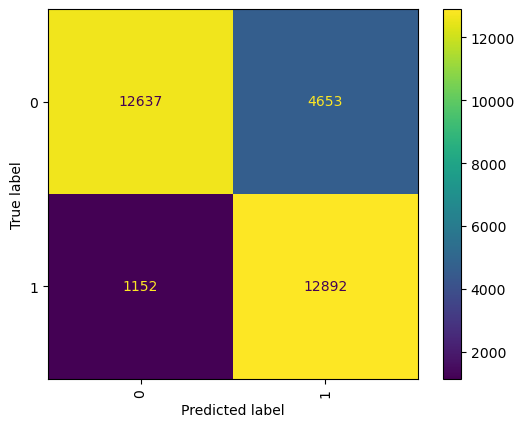

Exactitud:     0.815
Sensibilidad:  0.918
Especificidad: 0.731

=== Resultados con umbral = 0.5 ===


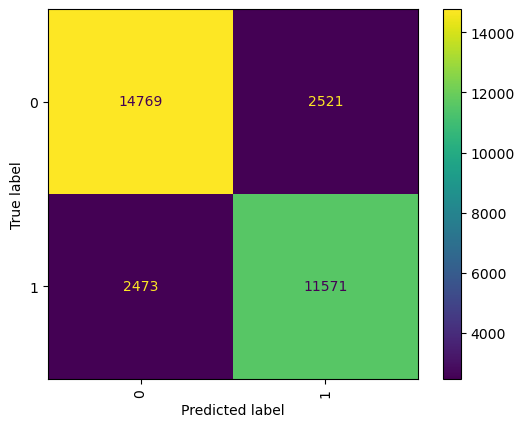

Exactitud:     0.841
Sensibilidad:  0.824
Especificidad: 0.854

=== Resultados con umbral = 0.7 ===


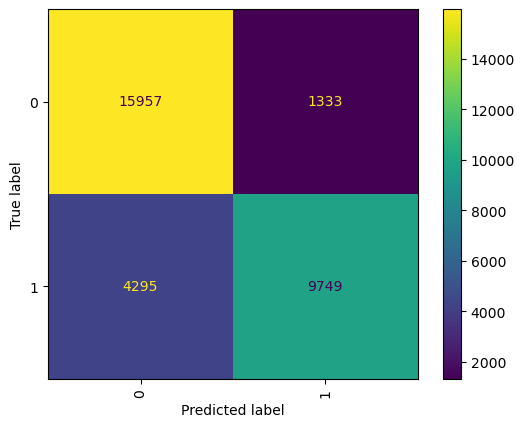

Exactitud:     0.820
Sensibilidad:  0.694
Especificidad: 0.923


In [85]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

# Definir umbrales
thresholds = [0.3, 0.5, 0.7]

for thr in thresholds:
    print(f"\n=== Resultados con umbral = {thr} ===")
    
    # Generar predicciones según el umbral
    preds_thr = (results["Prob_Clase_1"] >= thr).astype(int)
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, preds_thr)
    disp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    disp.plot(xticks_rotation="vertical")
    plt.show()
    
    # Calcular métricas
    acc = accuracy_score(y_test, preds_thr)
    sens = recall_score(y_test, preds_thr, pos_label=1)   # sensibilidad (TPR)
    espec = recall_score(y_test, preds_thr, pos_label=0)  # especificidad (TNR)
    
    print(f"Exactitud:     {acc:.3f}")
    print(f"Sensibilidad:  {sens:.3f}")
    print(f"Especificidad: {espec:.3f}")


**Resultados numéricos** *(extraídos de las matrices de confusión impresas)*:

| Umbral | TN | FP | FN | TP | Exactitud | Sensibilidad (TPR) | Especificidad (TNR) |
|:------:|---:|---:|---:|---:|:---------:|:-------------------:|:-------------------:|
| 0.3 | 12,637 | 4,653 | 1,152 | 12,892 | 0.815 | **0.918** | 0.731 |
| 0.5 | 14,769 | 2,521 | 2,473 | 11,571 | **0.841** | 0.824 | 0.854 |
| 0.7 | 15,957 | 1,333 | 4,295 | 9,749  | 0.820 | 0.694 | **0.923** |


> Convención de celdas:  
> **TN** = verdaderos negativos (clase 0 bien clasificada)  
> **FP** = falsos positivos (predijo 1 pero era 0)  
> **FN** = falsos negativos (predijo 0 pero era 1)  
> **TP** = verdaderos positivos (clase 1 bien clasificada)

Cuando el umbral se fijó en 0.3, el modelo se volvió más permisivo para declarar que un caso pertenecía a la clase 1. Esto provocó que la sensibilidad subiera hasta 0.918, es decir, se recuperó a casi todos los verdaderos positivos. Sin embargo, la contracara fue que la especificidad descendió a 0.731, ya que el modelo comenzó a confundir con mayor frecuencia a los negativos como positivos, produciendo más falsos positivos. Esta configuración es adecuada si lo más importante es no dejar escapar matrimonios con duración por encima del promedio, aunque ello implique marcar algunos casos de forma incorrecta.

En cambio, con un umbral más estricto de 0.7 la dinámica se invierte. La especificidad se elevó hasta 0.923, lo que significa que casi no se clasificaron falsamente como 1 los casos que en realidad eran 0. Sin embargo, la sensibilidad se redujo drásticamente a 0.694, reflejando que el modelo dejó pasar muchos positivos reales sin detectarlos (falsos negativos). Esta situación resulta útil cuando es más grave etiquetar incorrectamente a un 0 como 1 que dejar escapar a varios 1.

Finalmente, con el umbral estándar de 0.5, el modelo alcanzó el mejor balance entre ambas métricas. La sensibilidad fue de 0.824 y la especificidad de 0.854, lo que a su vez se reflejó en la exactitud más alta de los tres escenarios (0.841). En este punto se observa un equilibrio: el modelo no es excesivamente permisivo ni demasiado estricto, y mantiene un rendimiento aceptable en ambas direcciones.

## **Curva ROC y evaluación del área bajo la curva (AUC)**

A partir de las probabilidades de clase 1 calculadas por la regresión logística, se construyó la **curva ROC (Receiver Operating Characteristic)**. Esta curva grafica la relación entre la tasa de verdaderos positivos (sensibilidad) y la tasa de falsos positivos (1 − especificidad) a lo largo de todos los posibles valores de umbral de decisión. Además, se calculó el **área bajo la curva (AUC)**, que resume en un solo valor la capacidad discriminativa del modelo.


AUC: 0.923


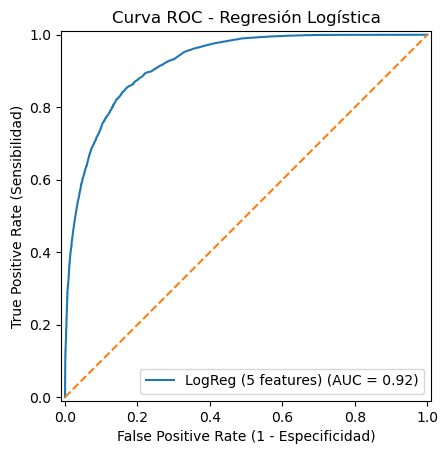

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

# y verdadero y puntajes (probabilidad de clase 1)
y_true = y_test.values if hasattr(y_test, "values") else y_test
y_score = results["Prob_Clase_1"].values  # del DataFrame que ya construiste

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)
auc_val = roc_auc_score(y_true, y_score)

print(f"AUC: {auc_val:.3f}")

# Gráfica ROC
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_val, estimator_name="LogReg (5 features)")
disp.plot()  # usa matplotlib por defecto
plt.plot([0,1],[0,1], linestyle="--")  # línea de azar (baseline)
plt.title("Curva ROC - Regresión Logística")
plt.xlabel("False Positive Rate (1 - Especificidad)")
plt.ylabel("True Positive Rate (Sensibilidad)")
plt.show()


Muestra una trayectoria muy por encima de la diagonal aleatoria (línea naranja), lo que indica que el modelo tiene un poder de discriminación significativo. El valor de AUC fue de **0.92**, lo cual se considera un desempeño sobresaliente en problemas de clasificación: significa que, si se selecciona al azar un caso positivo y un caso negativo, el modelo tiene un 92% de probabilidad de asignar una puntuación más alta al positivo.

El hecho de que la curva se mantenga muy cerca del vértice superior izquierdo refleja que el modelo logra mantener una alta sensibilidad sin sacrificar en exceso la especificidad.  

El AUC de 0.92 confirma que las 5 variables seleccionadas aportan información suficiente para distinguir con solidez entre matrimonios de duración mayor o menor al promedio. En términos prácticos, significa que el modelo tiene un desempeño confiable y que puede adaptarse a distintos escenarios, esto dependiendo de cómo se priorice el balance entre falsos positivos y falsos negativos. La curva ROC, si bien, no solo valida la calidad del modelo, si ofrece una herramienta para elegir el umbral óptimo según las necesidades específicas del análisis.

# **VII. Bibliografía**

Instituto Nacional de Estadística y Geografía. (2023). Estadísticas de divorcios, 2023 [Conjunto de datos]. INEGI. https://www.inegi.org.mx/app/descarga/ficha.html?tit=2340795&ag=0&f=csv